Attribute Information:

The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:

Sensor		Physical quantity		Unit		Sampling rate
PS1		Pressure			bar		100 Hz
PS2		Pressure			bar		100 Hz
PS3		Pressure			bar		100 Hz
PS4		Pressure			bar		100 Hz
PS5		Pressure			bar		100 Hz
PS6		Pressure			bar		100 Hz
EPS1		Motor power			W		100 Hz
FS1		Volume flow			l/min		10 Hz
FS2		Volume flow			l/min		10 Hz
TS1		Temperature			Â°C		1 Hz
TS2		Temperature			Â°C		1 Hz
TS3		Temperature			Â°C		1 Hz
TS4		Temperature			Â°C		1 Hz
VS1		Vibration			mm/s		1 Hz
CE		Cooling efficiency (virtual)	%		1 Hz
CP		Cooling power (virtual)		kW		1 Hz
SE		Efficiency factor		%		1 Hz



Has Missing Values?

No

In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#PS: Pressure, bar, 100 Hz --> 100 Messungen pro Sekunde
#EPS: Motor power, W, 100 Hz 
#FS: Volume flow, l/min, 10 Hz --> 10 Messungen pro Sekunde
#TS: Temperature, Celsius, 1 Hz --> 1 Messung pro Sekunde
#VS: Vibration, mm/s, 1Hz
#CE: Cooling efficiency (virtual), %, 1 Hz
#CP: Cooling power (virtual), kW, 1 Hz
#SE: Efficency factor, %, 1 Hz


class DataProcessor:
    def __init__(self, input_path, file_names):
        self.input_path = input_path
        self.file_names = file_names
        
    def read_files(self):
        self.data = {}
        print("Reading files...")
        for file in self.file_names:
            with open(self.input_path + file + '.txt', 'r') as f:
                self.data[file] = loadtxt(f)
        return self.data
    
    def print_shape(self):
        print("Files read:")
        for file in self.data:
            print(f"{file}: {self.data[file].shape}")
            
    def create_target_df(self):
        target_columns = ['Cooler_Condition', 'Valve_Condition', 
                        'Internal_Pump_Leakage', 'Hydraulic_Accumulator', 
                        'Stable_Flag']
        self.df_target = pd.DataFrame(self.data['target'], columns=target_columns)
        self.valve_condition = self.df_target['Valve_Condition']
        del self.data['target']
        return self.valve_condition

def process_data():
    input_path = "input_data/"
    file_names = [
        "ce", "cp", "eps1", "se", "vs1", 
        "fs1", "fs2", 
        "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
        "ts1", "ts2", "ts3", "ts4", "target"
    ]
    
    processor = DataProcessor(input_path, file_names)
    data = processor.read_files()
    processor.print_shape()
    processor.create_target_df()
    df_target = processor.valve_condition
    return data, df_target

data, df_target = process_data()

Reading files...
Files read:
ce: (2205, 60)
cp: (2205, 60)
eps1: (2205, 6000)
se: (2205, 60)
vs1: (2205, 60)
fs1: (2205, 600)
fs2: (2205, 600)
ps1: (2205, 6000)
ps2: (2205, 6000)
ps3: (2205, 6000)
ps4: (2205, 6000)
ps5: (2205, 6000)
ps6: (2205, 6000)
ts1: (2205, 60)
ts2: (2205, 60)
ts3: (2205, 60)
ts4: (2205, 60)
target: (2205, 5)


In [2]:
class DataPlotter:
    def __init__(self, dataset: dict):
        self.dataset = dataset
    
    def create_subplot(self):
        fig, axs = plt.subplots(6, 3, figsize=(15, 20))
        axes = axs.flatten()  
        for i, key in enumerate(self.dataset):
            ax = axes[i]
            ax.plot(self.dataset[key], color='blue', linewidth=1)
            ax.plot(np.mean(self.dataset[key], axis=1), color='red', linewidth=0.5)
            #ax.plot(np.var(self.dataset[key], axis=1), color='green')
            ax.set_title(key)
        plt.tight_layout()
        plt.show()
    
    def create_fft_plot(self):
        for key in self.dataset: 
            # Erstelle ein 2D-Array (z. B. eine Matrix)
            image = self.dataset[key]
            # 2D-Fourier-Transformation
            f_transform = np.fft.fft2(image)
            # Verschiebe den Nullfrequenzanteil in die Mitte des Spektrums
            f_transform_shifted = np.fft.fftshift(f_transform)
            # Berechne das Magnitudespektrum (Betrag)
            magnitude_spectrum = np.abs(f_transform_shifted)
            # Berechne das Phasenspektrum (Phase)
            phase_spectrum = np.angle(f_transform_shifted)
            # Summiere das Magnitudespektrum entlang der Spalten (horizontale Richtung)
            magnitude_spectrum_sum_cols = np.sum(magnitude_spectrum, axis=0)
            
            # Plots
            plt.figure(figsize=(12, 6))
            # Magnitudespektrum
            plt.subplot(1, 2, 1)
            plt.plot(magnitude_spectrum_sum_cols)
            plt.title(f"{key}: Magnitude Spectrum (Summe entlang der Spalten)")
            plt.xlabel("Spalten-Index")
            plt.ylabel("Summierte Magnitude")
            # Phasenspektrum
            plt.subplot(1, 2, 2)
            plt.imshow(phase_spectrum, cmap='twilight', aspect='auto')
            plt.title(f"{key}: Phase Spectrum")
            plt.colorbar(label='Phase (radians)')
            plt.tight_layout()
            plt.show()
            
plot = DataPlotter(data)

In [ ]:
# Umwandlung in Pandas-DataFrame
df = pd.DataFrame(data["eps1"])
df

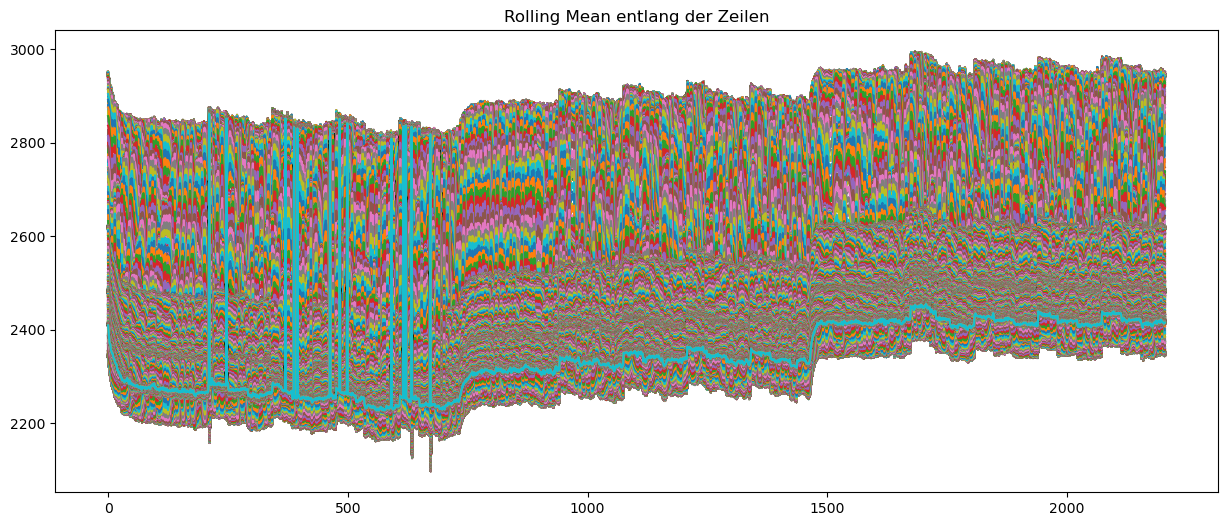

In [3]:
data_set = data["eps1"]
rolling_means_rows = np.array([
    pd.Series(row).rolling(window= 10).mean()
    for row in data_set
])


fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(rolling_means_rows)
ax.set_title("Rolling Mean entlang der Zeilen")
plt.show()

Einzelne Signale plotten --> Ausreiser und Trends erkennen


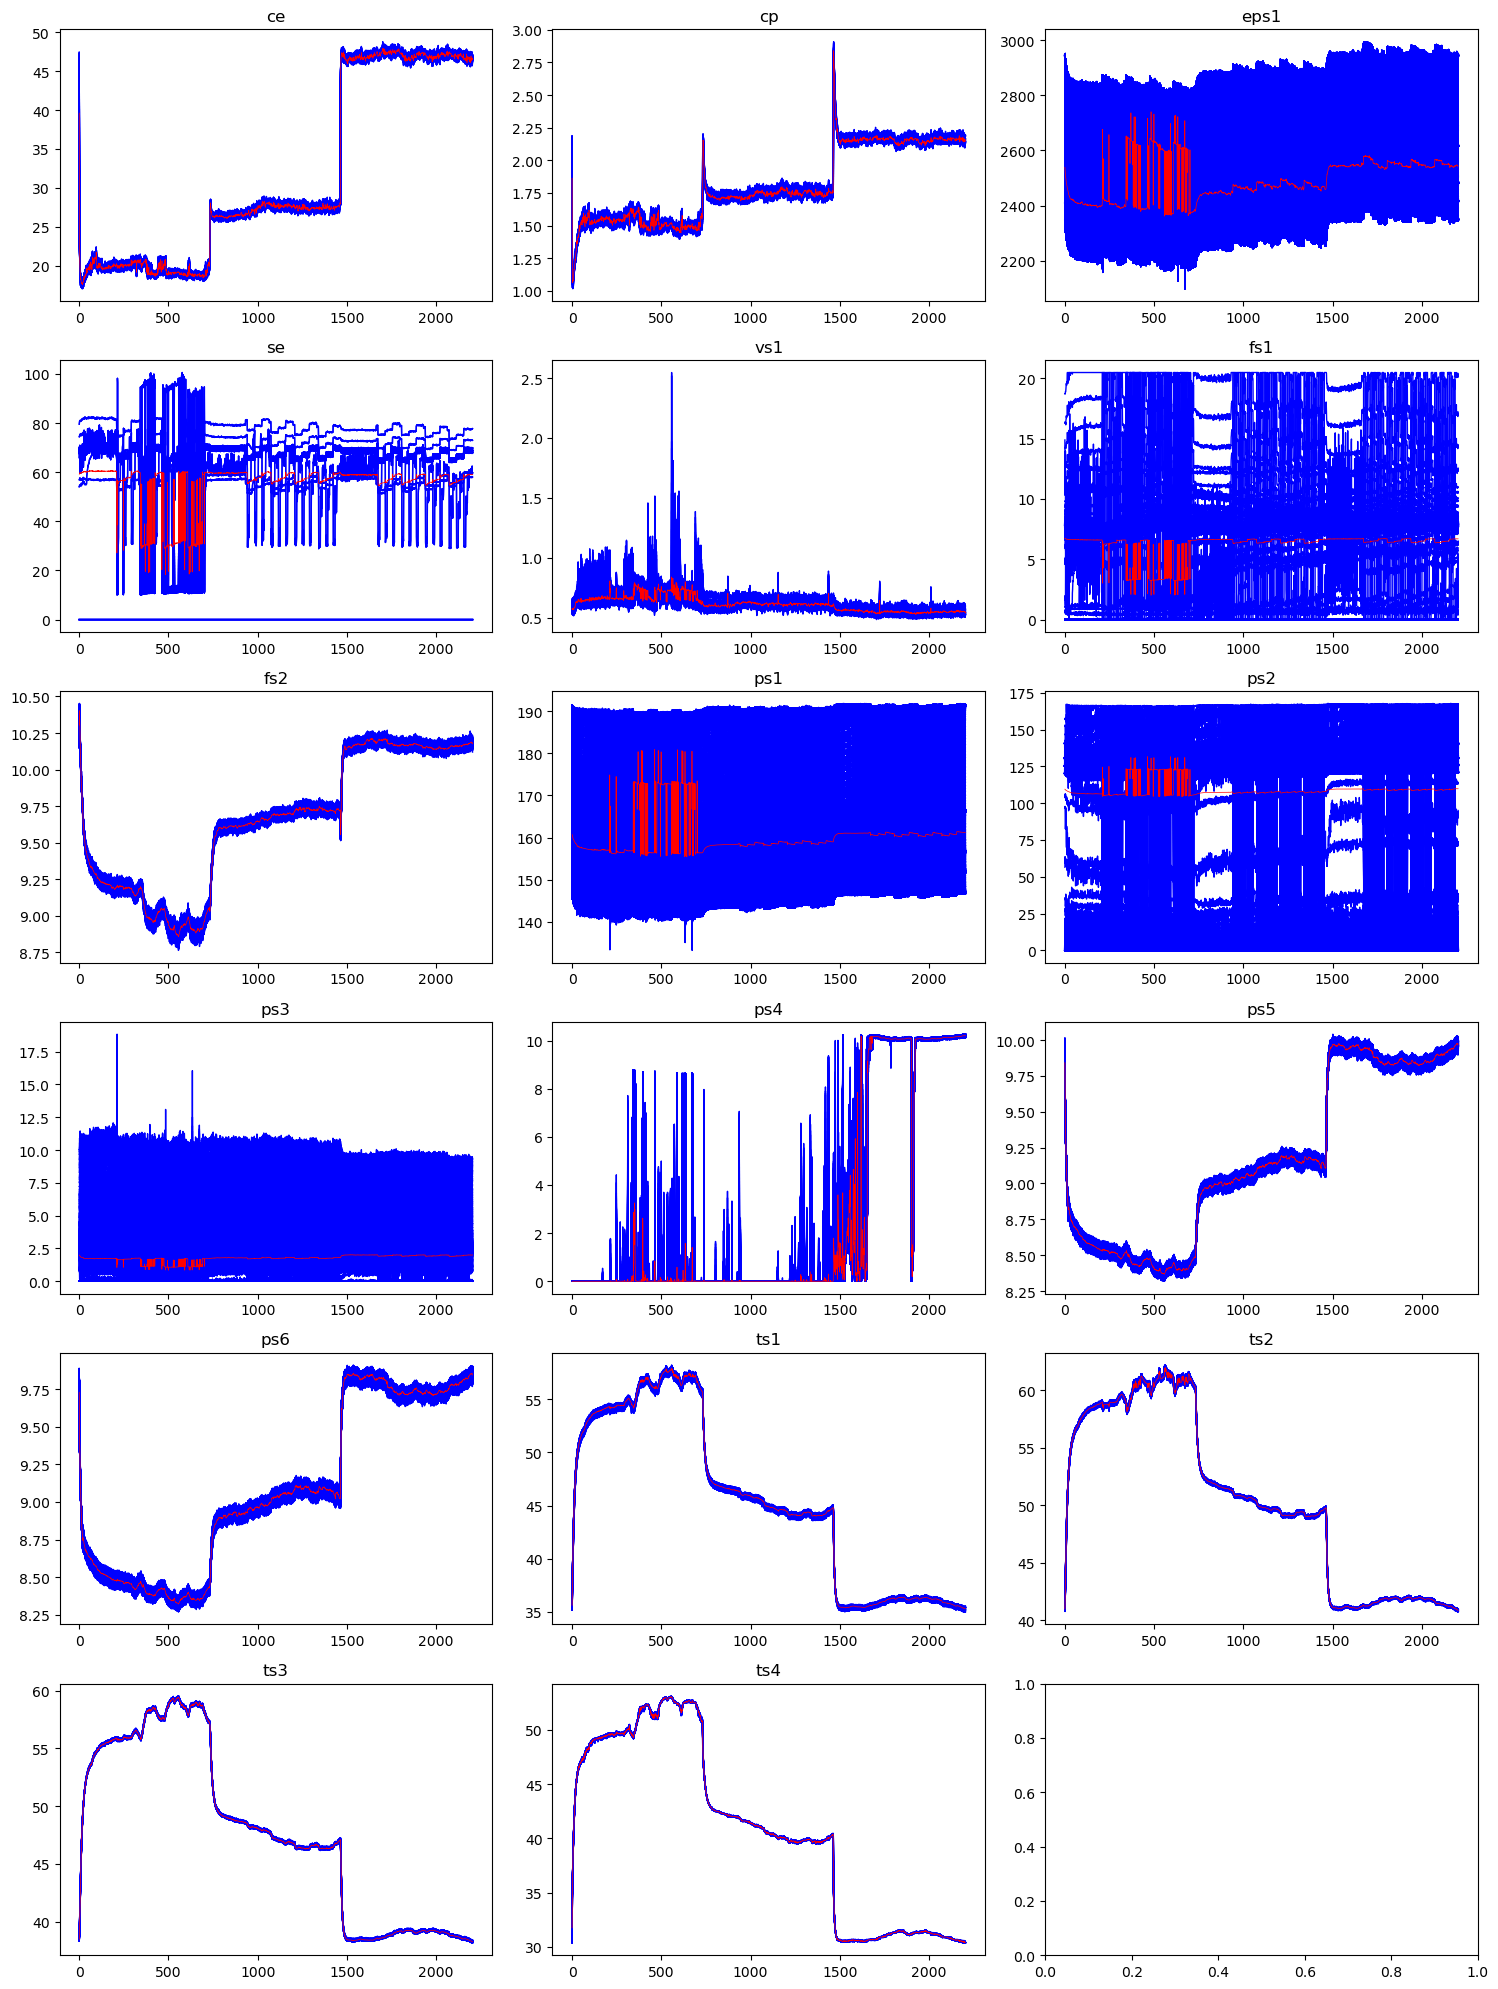

In [17]:
plot.create_subplot()

In [ ]:
plot.create_fft_plot()

In [8]:
#einzelne Signale in Means abspeichern
data_means = {}
for key in data:
    data_means[key] = np.mean(data[key], axis=1)

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(15, 20))
axes = axs.flatten()  
for i, key in enumerate(data_means):
    ax = axes[i]
    ax.plot(data_means[key], color='blue', linewidth=1)
    ax.set_title(key)
plt.tight_layout()
plt.show()

In [235]:
data_means_df = pd.DataFrame(data_means)

In [236]:
for column in data_means_df.columns:
    data_means_df[column] = data_means_df[column].rolling(window=10, min_periods=1).mean()

In [ ]:
for column in data_means_df.columns:
    data_means_df[column].plot(kind='line', title='Values Plot', xlabel='Index', ylabel='Values')
    plt.show()

In [98]:
class ManualFeatureExtractor:
    def __init__(self, dataset):
        self.dataset = dataset
        
    def extract_features(self):
        features = {}
        for i, key in enumerate(self.dataset, start=1):
            #features[f"{key}_{i}_mean"] = self.dataset[key].mean(axis=1)
            #features[f"{key}_{i}_median"] = np.median(self.dataset[key], axis=1)
            features[f"{key}_{i}_std"] = self.dataset[key].std(axis=1)
            #features[f"{key}_{i}_min"] = self.dataset[key].min(axis=1)
            #features[f"{key}_{i}_max"] = self.dataset[key].max(axis=1)
            #features[f"{key}_{i}_range"] = self.dataset[key].max(axis=1) - self.dataset[key].min(axis=1)
        self.df_features = pd.DataFrame(features)
        return self.df_features

extractor = ManualFeatureExtractor(data)
df_features = extractor.extract_features()

In [ ]:
print(df_features.shape, df_target.shape)

In [ ]:
nan_count_per_row = data_means_df.isna().sum(axis=1)
print(nan_count_per_row)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

  
states = [27, 6728, 49122]
accs = []
features = df_features
target = df_target

for RANDOM_STATE in states:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify = target
    )
    
    model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))

accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

1. Entferne Ausreißer...
2. Glätte das Signal mit Moving Average...
3. Interpoliere fehlende Werte...
4. Glätte weiter mit Savitzky-Golay-Filter...
[[2538.92916667]
 [2535.21403333]
 [2530.11868889]
 ...
 [2545.81156333]
 [2545.64940333]
 [2545.41501667]]


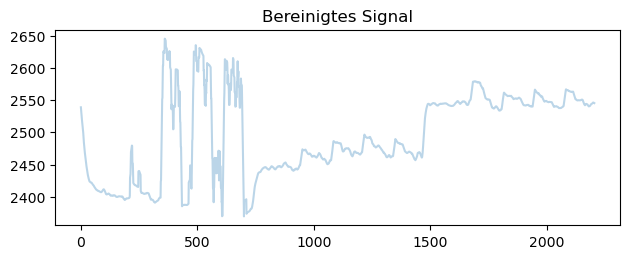

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Beispiel: Lade dein 2D-Signal (2205 x 6000)
# Ersetze dies mit deinem tatsächlichen Signal
# signal = np.loadtxt('your_signal_file.csv')  # Falls als Datei vorliegt
signal = np.random.rand(2205, 6000) * 100  # Dummy-Daten zum Testen

# 1. Funktion: Ausreißer entfernen
def remove_outliers(data, threshold=3):
    """
    Entfernt Ausreißer anhand des Z-Scores.
    data: 2D-Array (Zeilen: Kanäle, Spalten: Zeitpunkte)
    threshold: Schwellenwert für Z-Score
    """
    z_scores = (data - np.mean(data, keepdims=True)) / np.std(data, keepdims=True)
    data_cleaned = np.where(np.abs(z_scores) > threshold, np.median(data, keepdims=True), data)
    return data_cleaned

# 2. Funktion: Gleitender Durchschnitt (Moving Average)
def smooth_signal(data, window_size=11):
    """
    Glättet das Signal mit einem gleitenden Durchschnitt.
    data: 2D-Array (Zeilen: Kanäle, Spalten: Zeitpunkte)
    window_size: Fenstergröße für den gleitenden Durchschnitt
    """
    return pd.DataFrame(data).rolling(window=window_size,min_periods=1).mean().values


# Pipeline zur Signalbereinigung
def clean_signal(signal):
    print("1. Entferne Ausreißer...")
    signal_cleaned = remove_outliers(signal)

    print("2. Glätte das Signal mit Moving Average...")
    signal_smoothed = smooth_signal(signal_cleaned, window_size=10)

    return signal_smoothed

# Bereinigung anwenden

data_cleaned
cleaned_signal = clean_signal(data_means['eps1'])

print(cleaned_signal)

# # Visualisierung des Original- und bereinigten Signals
# plt.figure(figsize=(20, 8))
# plt.subplot(2, 1, 1)
# plt.title("Originales Signal")
# plt.plot(signal, alpha=0.3)  # Transponieren für bessere Visualisierung'

plt.subplot(2, 1, 2)
plt.title("Bereinigtes Signal")
plt.plot(cleaned_signal, alpha=0.3)  # Transponieren für bessere Visualisierung
plt.tight_layout()
plt.show()


Merker für nach Urlaub: Datensätze von Sensoren, die mehrere Aufzeichnungen haben, zusammenführen, um einen großen Datensatz zu erhalten. Daraus dann wieder Standardabweichungen berechnen und in das Modell geben